**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

*Edición 2022*

----

# Trabajo Practico Aprendizaje Supervisado

In [1]:
#Importamos las librerias necesarias

import numpy as np
import pandas as pd
import plotly as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#Definimos el estilo de los gráficos

PiYG_r = sns.color_palette("YlGnBu_r", 10)
sns.set_palette(PiYG_r)
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("talk", font_scale = .5, rc={"grid.linewidth": 0.6})
color1 = PiYG_r[1]
color2 = PiYG_r[6]
color3 = PiYG_r[5]

<Figure size 432x288 with 0 Axes>

En este laboratorio vamos a trabajar sobre la competencia de Kaggle [Spaceship Titanic](https://https://www.kaggle.com/competitions/spaceship-titanic/data)

El objetivo de este lab es predecir que pasajeros fueron transportados a una dimensión alternativa durante el choque de la nave espacial. 

## Conjunto de Datos

Trabajamos sobre los conjuntos de datos ofrecidos por la plataforma; contenidos en dos archivos: train.csv y test.csv

> **train.csv**

Contiene información pérsonal sobre dos tercios de los pasajeros de la nave espacial. Estos son los datos que se deben utilizar para para entrenar y validar el modelo.

In [3]:
#Importamos los datos de entrenamiento
analisis_url = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv'
df_orig = pd.read_csv(analisis_url)

df_analisis = df_orig.copy() #Hacemos una copia
df_analisis.shape

(7823, 14)

El dataset sobre el que vamos a trabajar contiene 7823 registros y 14 columnas.

In [4]:
df_analisis.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.00,False,0.00,3859.00,13.00,195.00,3874.00,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.00,False,0.00,0.00,0.00,0.00,0.00,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.00,NaN,0.00,0.00,0.00,0.00,0.00,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.00,False,142.00,1208.00,0.00,0.00,204.00,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.00,False,0.00,0.00,670.00,1.00,34.00,Gracy Dunnisey,0


El conjunto de entrenamiento contiene las siguientes columnas:

- `PassengerId` - A unique Id for each passenger.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Nuestro objetivo es determinar si un pasajero pertenece a la clase que fue transportada a la dimensión alternativa o no. Esto está indicado por la columna `Transported`, que indica con el valor `'True'` a los pasajeros que fueron transportados y `'False'` a los que no. 

In [5]:
#Balance de clases
df_analisis['Transported'].value_counts()

1    3964
0    3859
Name: Transported, dtype: int64

Del total de registros de la base de datos, 3964 pertenecen a la clase transportada y 3859 a la no transportada; por lo que podríamos decir que el dataset está balanceado.

> **test.csv:**  


Contiene datos personales sobre el tercio restante de pasajeros de la nave espacial, estos son los datos que van a usarse para testear el modelo. Nuestra tarea es realizar predicciones sobre la clase a la que pertenecen los pasajeros de este conjunto de datos.

In [6]:
#Importamos los datos de test

test_url = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/test.csv'
df_test_original = pd.read_csv(test_url)

df_test_analisis = df_test_original.copy() #copia
df_test_analisis.shape

(870, 13)

Este dataset contiene 870 registros y posee las mismas columnas que las del dataframe de entrenamiento, excepto porque no posee la columna target. 



#Analisis y Preprocesamiento

## Analisis Exploratorio

Lo primero que debemos realizar es analizar los datos para entender con qué estamos tratando y hacernos una idea de cuales pueden ser las features más interesantes.

### Variables Numericas

Empezamos analizando las variables numéricas. `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` refieren a cuanto gastó el pasajero en cada uno de esos lugares. 

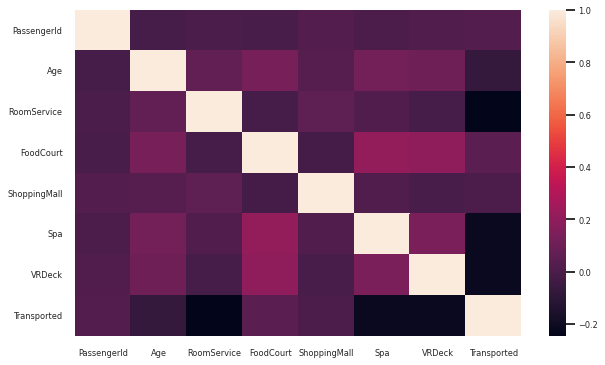

In [7]:
#Matriz de correlación
plt.figure(figsize=(10,6))
sns.heatmap(df_analisis.corr(), 
        xticklabels=df_analisis.corr().columns,
        yticklabels=df_analisis.corr().columns)

Observamos que, en un principio, no parecería haber una fuerte correlación entre las variables numericas con la variable target. Vamos a hacer un describe para profundizar:

In [8]:
# Describe para usuarios transportados
df_analisis[df_analisis.Transported == True].describe()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,3964.00,3882.00,3895.00,3878.00,3859.00,3886.00,3875.00,3964.00
mean,4400.41,27.84,61.29,532.86,175.21,63.30,68.80,1.00
std,2451.06,15.12,270.88,1955.91,702.85,269.32,286.21,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,2350.50,18.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,4494.50,26.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,6425.50,37.00,0.00,0.00,0.00,0.00,0.00,1.00
max,8692.00,78.00,3992.00,29813.00,23492.00,4103.00,4088.00,1.00


In [9]:
#Describe para usuarios No trasportados
df_analisis[df_analisis.Transported == False].describe()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,3859.00,3779.00,3774.00,3790.00,3776.00,3779.00,3779.00,3859.00
mean,4289.49,29.95,396.15,376.63,169.93,553.59,527.91,0.00
std,2557.48,13.67,897.10,1179.88,467.01,1552.27,1493.78,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2043.50,21.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,4159.00,27.00,1.00,0.00,0.00,3.00,1.00,0.00
75%,6632.00,38.00,478.50,168.75,96.25,436.50,392.00,0.00
max,8691.00,79.00,14327.00,16856.00,10705.00,22408.00,24133.00,0.00


Los usuarios No transportados parecerían ser levemente más grandes de edad que los transportados. Además, los No transportados habrían gastado más, en promedio, en RoomService,Spa y VRDeck, pero menos en FoodCourt. También, observamos una fuerte presencia de outliers.

### Categóricas

Ahora veamos que variables categóricas pueden estar más relacionadas a la variable target. Para ello, vamos a separar el df en dos: pasajeros transportados y pasajeros no transportados. 

Luego, utilizaremos gráficos para analizar las variables. 

In [10]:
#Separamos entre usuarios transportados y no transportados para comparar comportamiento

transported = df_analisis['Transported'] == True

df_transported = df_analisis[transported] #df where users are transported
df_stayed = df_analisis[~transported] #df where users are NOT transported
df_transported.shape, df_stayed.shape

((3964, 14), (3859, 14))

> #### Pais de Origen

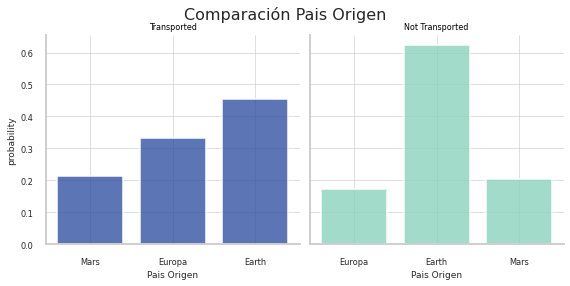

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True);
fig.suptitle('Comparación Pais Origen', size = 16) #Titulo para la figura

#Grafico Usuarios Transportados
transported = sns.histplot(df_transported.HomePlanet, discrete=True,
                      shrink=.8, stat="probability", ax = axes[0], color = color1);

transported.set_title("Transported", size=8, color='black');

#Grafico Usuarios No Transportados
not_transported = sns.histplot(df_stayed.HomePlanet, discrete=True, shrink=.8, stat="probability",
                         ax = axes[1], color = color2);

not_transported.set_title("Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='Pais Origen', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Notamos que hay diferencias entre el lugar de origen y destino de los individuos que sufrieron el traslado luego del accidente, de los que no. Por ejemplo, observamos que entre los individuos trasladados, es más pareja la distribución entre país de origen; mientras que entre los no trasladados, es más fuerte de pasajeros originarios del planeta tierra. 

> #### Pais de Destino

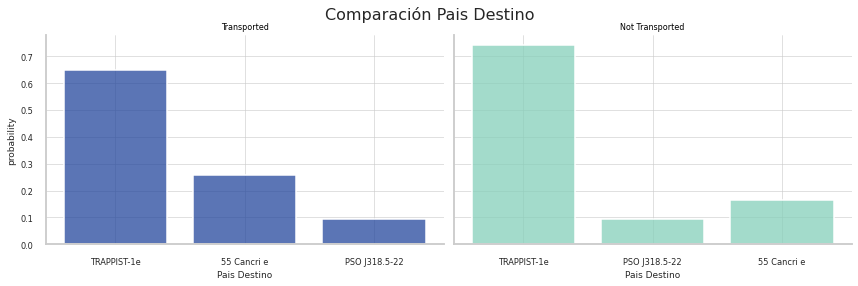

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True);
fig.suptitle('Comparación Pais Destino', size = 16) #Titulo para la figura

#Grafico Usuarios Transportados
transported = sns.histplot(df_transported.Destination, discrete=True,
                      shrink=.8, stat="probability", ax = axes[0],color = color1);

transported.set_title("Transported", size=8, color='black');

#Grafico Usuarios No Transportados
not_transported = sns.histplot(df_stayed.Destination, discrete=True, shrink=.8, stat="probability",
                         ax = axes[1],color = color2);

not_transported.set_title("Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='Pais Destino', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

En cuanto al país de destino, observamos que entre los no trasladados, la presencia de pasajeros con destrino a Crancri es más alta que entre los trasladados. 

> #### Status (VIP vs Estandar)

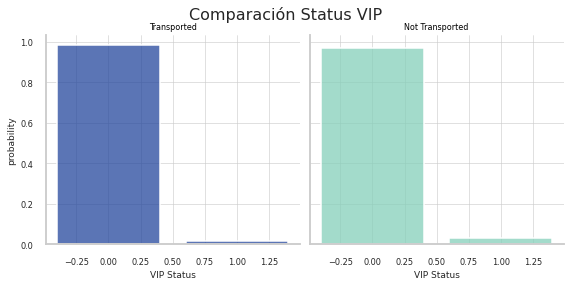

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True);
fig.suptitle('Comparación Status VIP', size = 16) #Titulo para la figura

#Grafico Usuarios Transportados
transported = sns.histplot(df_transported.VIP, discrete=True,
                      shrink=.8, stat="probability", ax = axes[0],color = color1);

transported.set_title("Transported", size=8, color='black');

#Grafico Usuarios No Transportados
not_transported = sns.histplot(df_stayed.VIP, discrete=True, shrink=.8, stat="probability",
                         ax = axes[1],color = color2);

not_transported.set_title("Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='VIP Status', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

No se observan diferencias considerables con respecto a estas variables.

> #### CryoSleep

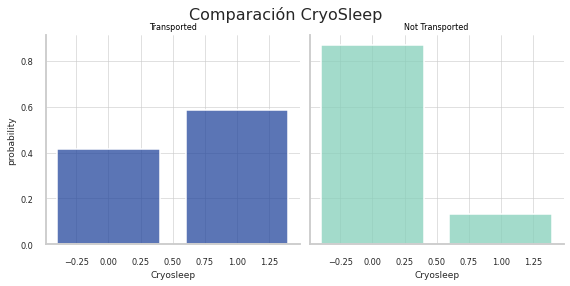

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True);
fig.suptitle('Comparación CryoSleep', size = 16) #Titulo para la figura

#Grafico Usuarios Transportados
transported = sns.histplot(df_transported.CryoSleep, discrete=True,
                      shrink=.8, stat="probability", ax = axes[0],color = color1);

transported.set_title("Transported", size=8, color='black');

#Grafico Usuarios No Transportados
stay = sns.histplot(df_stayed.CryoSleep, discrete=True, shrink=.8, stat="probability",
                         ax = axes[1],color = color2);

stay.set_title("Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cryosleep', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Esta variable muestra una gran distinción en su distribución respecto a las dos clases. Por lo que puede ser considerada importante para la predicción.

##Preprocesamiento Train

Ahora que ya sabemos como se relacionan las distintas variables con nuestra columna target, debemos preparar los datos para poder aplicar el modelo. Iniciamos preparando el conjunto de train.

### Datos Faltantes

Vamos a comenzar analizando si hay valores nulos en nuestro dataset de entrenamiento

In [15]:
#trabajamos sobre una copia

df_imputed = df_analisis.copy()

In [16]:
df_imputed.isnull().sum(axis = 0)

PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService     154
FoodCourt       155
ShoppingMall    188
Spa             158
VRDeck          169
Name            184
Transported       0
dtype: int64

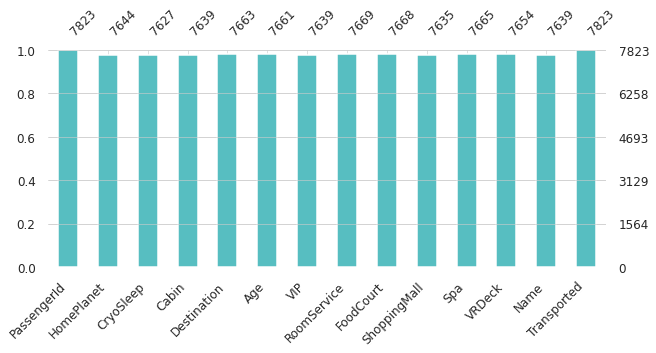

In [17]:
import missingno as msno
msno.bar(df_imputed,figsize=(10, 4), fontsize=12, color=color3)

Notamos que los valores faltantes representan una proporción pequeña del conjunto total de datos.

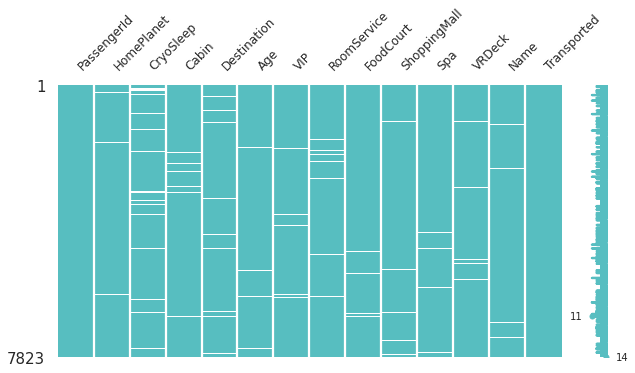

In [18]:
#Matriz de posiciones de datos faltantes
msno.matrix(df_imputed, figsize=(10, 5), fontsize=12, color=color3)

Notamos que en un principio, no habría mayor correlación entre los datos faltantes de una variable con los de otra.

> #### Consumo de Servicios

Comencemos imputando los valores faltates para las columnas de consumo de servicios. 

- Para todos los menores de 13 años, el nivel de consumo en servicios es nulo. Por lo que a todos los faltantes de estas columnas para pasajeros menores de 13 años de edad, podemos remplazarlos por cero.

- Al resto, vamos a remplazarlos por la mediana del nivel de gasto de ese servicio.

In [19]:
#Cuanto gastan en promedio por edad en cada servicio
df_imputed.groupby('Age').agg({'ShoppingMall':'mean','FoodCourt':'mean','VRDeck':'mean','Spa':'mean','RoomService':'mean'}).head(14)

,ShoppingMall,FoodCourt,VRDeck,Spa,RoomService
Age,,,,,
0.00,0.00,0.00,0.00,0.00,0.00
1.00,0.00,0.00,0.00,0.00,0.00
2.00,0.00,0.00,0.00,0.00,0.00
3.00,0.00,0.00,0.00,0.00,0.00
4.00,0.00,0.00,0.00,0.00,0.00
5.00,0.00,0.00,0.00,0.00,0.00
6.00,0.00,0.00,0.00,0.00,0.00
7.00,0.00,0.00,0.00,0.00,0.00
8.00,0.00,0.00,0.00,0.00,0.00


In [20]:
#Remplazamos para los menores de edad
df_imputed.FoodCourt=np.where(df_imputed.Age < 13, df_imputed.FoodCourt.fillna(0),df_imputed.FoodCourt)
df_imputed.ShoppingMall=np.where(df_imputed.Age < 13, df_imputed.ShoppingMall.fillna(0),df_imputed.ShoppingMall)
df_imputed.RoomService=np.where(df_imputed.Age < 13, df_imputed.RoomService.fillna(0),df_imputed.RoomService)
df_imputed.Spa=np.where(df_imputed.Age < 13, df_imputed.Spa.fillna(0),df_imputed.Spa)
df_imputed.VRDeck=np.where(df_imputed.Age < 13, df_imputed.VRDeck.fillna(0),df_imputed.VRDeck)

In [21]:
#Remplazamos para los mayores de edad
df_imputed.FoodCourt=np.where(df_imputed.Age > 12, df_imputed.FoodCourt.fillna(df_imputed.FoodCourt.median()),df_imputed.FoodCourt)
df_imputed.ShoppingMall=np.where(df_imputed.Age > 12, df_imputed.ShoppingMall.fillna(df_imputed.ShoppingMall.median()),df_imputed.ShoppingMall)
df_imputed.RoomService=np.where(df_imputed.Age > 12, df_imputed.RoomService.fillna(df_imputed.RoomService.median()),df_imputed.RoomService)
df_imputed.Spa=np.where(df_imputed.Age > 12, df_imputed.Spa.fillna(df_imputed.Spa.median()),df_imputed.Spa)
df_imputed.VRDeck=np.where(df_imputed.Age > 12, df_imputed.VRDeck.fillna(df_imputed.VRDeck.median()),df_imputed.VRDeck)

In [22]:
#Remplazamos para los pasajeros donde Age es Nan
df_imputed.FoodCourt=np.where(df_imputed.Age.isnull(),df_imputed.FoodCourt.fillna(df_imputed.FoodCourt.median()),df_imputed.FoodCourt)
df_imputed.ShoppingMall=np.where(df_imputed.Age.isnull(),df_imputed.ShoppingMall.fillna(df_imputed.ShoppingMall.median()),df_imputed.ShoppingMall)
df_imputed.RoomService=np.where(df_imputed.Age.isnull(), df_imputed.RoomService.fillna(df_imputed.RoomService.median()), df_imputed.RoomService)
df_imputed.Spa=np.where(df_imputed.Age.isnull(), df_imputed.Spa.fillna(df_imputed.Spa.median()),df_imputed.Spa)
df_imputed.VRDeck=np.where(df_imputed.Age.isnull(), df_imputed.VRDeck.fillna(df_imputed.VRDeck.median()),df_imputed.VRDeck)

In [23]:
df_imputed.isnull().sum(axis = 0) 

PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            184
Transported       0
dtype: int64

> #### Home Planet y Destination


Imputamos por el valor más frecuente

In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
df_imputed[['Destination','HomePlanet']]= imputer.fit_transform(df_imputed[['Destination','HomePlanet']])

In [25]:
df_imputed[['Destination','HomePlanet']].isnull().sum(axis = 0) 

Destination    0
HomePlanet     0
dtype: int64

> #### VIP y Name

Estas variables no son relevantes para el análisis, por lo que podemos eliminar la columna directamente. 

In [26]:
df_imputed.drop(columns=['VIP','Name'], inplace=True)

> #### Age

Para la variable edad imputamos los valores faltantes por la mediana. 

In [27]:
df_imputed.Age = df_imputed.Age.fillna(df_imputed.Age.median())

In [28]:
df_imputed.Age.isnull().sum(axis = 0) 

0

> #### Cabin y CryoSleep

En este caso, como consideramos que las variables son importantes, optamos por imputar con KNN. Para ello, es necesario hacer otras transformaciones primero. 

### Agregamos Columnas Nuevas

In [29]:
df_new_cols = df_imputed.copy()

> #### Uso de servicios

Además, del nivel de consumo que los pasajeros mantienen en los servicios que se ofrecen en la nave, creemos que podría ser interesante evaluar si los servicios se utilizan o no. De esta manera, creamos nuevas columnas para cada uno de los servicios que nos indican con `1` si el servicio fue utilizado y con `0` si no fue utilizado.


In [30]:
#Creamos una función
def used_service(spend_amount):
  if spend_amount > 0:
    return 1
  else:
    if spend_amount:
      return None
    else:
      return 0

In [31]:
#Agregamos las columnas para el conjunto de Entrenamiento

df_new_cols.loc[:, 'UsedSpa'] = df_new_cols.Spa.apply(used_service)
df_new_cols.loc[:, 'UsedFoodCourt'] = df_new_cols.FoodCourt.apply(used_service)
df_new_cols.loc[:, 'UsedRoomService'] = df_new_cols.RoomService.apply(used_service)
df_new_cols.loc[:, 'UsedVRD'] = df_new_cols.VRDeck.apply(used_service)
df_new_cols.loc[:, 'UsedShoppingMall'] = df_new_cols.ShoppingMall.apply(used_service)

In [32]:
#Nuevas columnas
df_new_cols[['UsedSpa','UsedRoomService','UsedFoodCourt','UsedVRD','UsedShoppingMall']].head(5)

,UsedSpa,UsedRoomService,UsedFoodCourt,UsedVRD,UsedShoppingMall
0,1,0,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,1,1,1,0
4,1,0,0,1,1


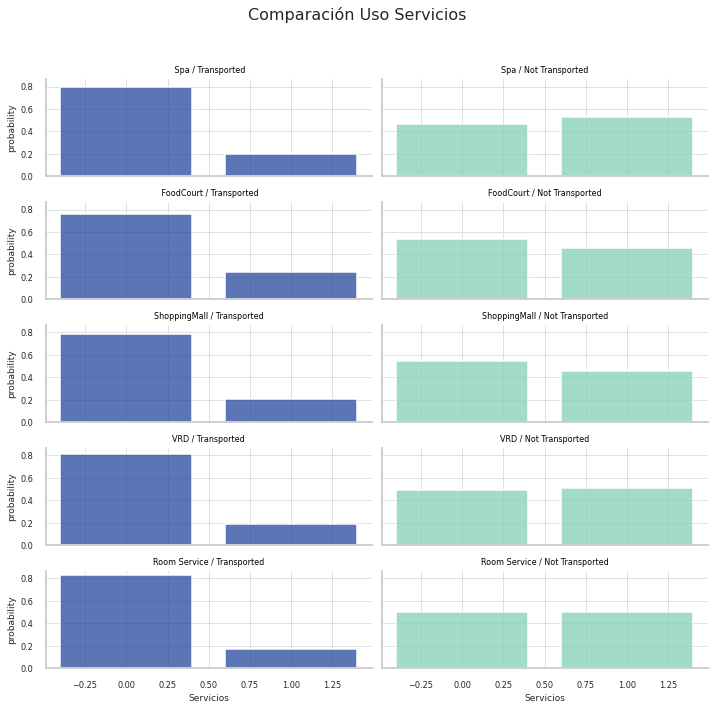

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10), sharey=True);
fig.suptitle('Comparación Uso Servicios', size = 16) #Titulo para la figura

#Grafico Usuarios spa Transportados
transported_spa = sns.histplot(df_new_cols[df_new_cols.Transported == True].UsedSpa, 
                               discrete=True, shrink=.8, stat="probability", ax = axes[0,0], color = color1);
transported_spa.set_title(" Spa / Transported", size=8, color='black');

#Grafico Usuarios Spa No Transportados
not_transported_spa = sns.histplot(df_new_cols[df_new_cols.Transported == False].UsedSpa, 
                                   discrete=True, shrink=.8, stat="probability", ax = axes[0,1],color = color2);
not_transported_spa.set_title("Spa / Not Transported", size=8, color='black');

#Grafico Usuarios FoodCourt Transportados
transported_fc = sns.histplot(df_new_cols[df_new_cols.Transported ==True].UsedFoodCourt, 
                              discrete=True, shrink=.8, stat="probability", ax = axes[1,0],color = color1);
transported_fc.set_title(" FoodCourt / Transported", size=8, color='black');

#Grafico Usuarios FoodCourt No Transportados
not_transported_fc = sns.histplot(df_new_cols[df_new_cols.Transported == False].UsedFoodCourt, 
                                  discrete=True, shrink=.8, stat="probability", ax = axes[1,1],color = color2);
not_transported_fc.set_title("FoodCourt / Not Transported", size=8, color='black');

#Grafico Usuarios ShoppingMall Transportados
transported_sm = sns.histplot(df_new_cols[df_new_cols.Transported ==True].UsedShoppingMall,
                              discrete=True, shrink=.8, stat="probability", ax = axes[2,0],color = color1);
transported_sm.set_title("ShoppingMall / Transported", size=8, color='black');

#Grafico Usuarios ShoppingMall No Transportados
not_transported_sm = sns.histplot(df_new_cols[df_new_cols.Transported == False].UsedShoppingMall, 
                                  discrete=True, shrink=.8, stat="probability", ax = axes[2,1],color = color2);
not_transported_sm.set_title("ShoppingMall / Not Transported", size=8, color='black');

#Grafico Usuarios VRD Transportados
transported_vrd = sns.histplot(df_new_cols[df_new_cols.Transported ==True].UsedVRD, 
                               discrete=True, shrink=.8, stat="probability", ax = axes[3,0],color = color1);
transported_vrd.set_title("VRD / Transported", size=8, color='black');

#Grafico Usuarios VRD No Transportados
not_transported_vrd = sns.histplot(df_new_cols[df_new_cols.Transported == False].UsedVRD, 
                                   discrete=True, shrink=.8, stat="probability", ax = axes[3,1],color = color2);
not_transported_vrd.set_title("VRD / Not Transported", size=8, color='black');

#Grafico Usuarios RoomService Transportados
transported_rs = sns.histplot(df_new_cols[df_new_cols.Transported ==True].UsedRoomService, 
                              discrete=True, shrink=.8, stat="probability", ax = axes[4,0],color = color1);
transported_rs.set_title("Room Service / Transported", size=8, color='black');

#Grafico Usuarios RoomService No Transportados
not_transported_rs = sns.histplot(df_new_cols[df_new_cols.Transported == False].UsedRoomService, 
                                  discrete=True, shrink=.8, stat="probability", ax = axes[4,1],color = color2);
not_transported_rs.set_title("Room Service / Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='Servicios', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Notamos que si hay diferencia entre clases con respecto a las variables que construimos que nos indican si el pasajero uso o no ese servicio (Spa/RoomService /VRDeck / Shopping Mall / FoodCourt)

> #### Cabin

Por otro lado, la columna `Cabin` trae información respecto al Deck, Numero y Side en el que se encuentra la cabina. Esto puede separarse para un mejor analisis. Así, podemos crear las columnas: 

- `CabinDeck`
- `CabinNumber`
- `CabinSide`

In [34]:
df_new_cols.Cabin[:5]

0     C/123/P
1     F/126/S
2     B/343/S
3    F/1420/P
4       G/9/P
Name: Cabin, dtype: object

In [35]:
#Creamos una función que devuelva el deck
def split_deck(cabin_str):
  if not isinstance(cabin_str, str):
    return None
  try:
    deck = re.split("/+", cabin_str, maxsplit=2)[0]
    return deck
  except AttributeError:
    deck = None
    return deck

#Creamos una función que devuelva el numero de cabina
def split_cnum(cabin_str):
  if not isinstance(cabin_str, str):
    return None
  try:
    cnum = re.split("/+", cabin_str, maxsplit=2)[1]
    return cnum
  except AttributeError:
    cnum = None
    return cnum

#Creamos una función que devuelva el lado de la cabina
def split_side(cabin_str):
  if not isinstance(cabin_str, str):
    return None
  try:
    side = re.split("/+", cabin_str, maxsplit=2)[2]
    return side
  except AttributeError:
    side = None
    return side

In [36]:
#aplicamos la función al df de entrenamiento
df_new_cols.loc[:, 'CabinDeck'] = df_new_cols.Cabin.apply(split_deck)
df_new_cols.loc[:, 'CabinNumber'] = df_new_cols.Cabin.apply(split_cnum)
df_new_cols.loc[:, 'CabinSide'] = df_new_cols.Cabin.apply(split_side)

In [37]:
#Nuevas columnas
df_new_cols[['Cabin','CabinDeck','CabinNumber','CabinSide']].head(5)

,Cabin,CabinDeck,CabinNumber,CabinSide
0,C/123/P,C,123,P
1,F/126/S,F,126,S
2,B/343/S,B,343,S
3,F/1420/P,F,1420,P
4,G/9/P,G,9,P


In [38]:
#Sacamos la columna Cabin pues ya no nos sirve
df_new_cols.drop(columns='Cabin', inplace=True)

Veamos ahora si hay alguna diferencia entre las clases respecto a estas nuevas variables

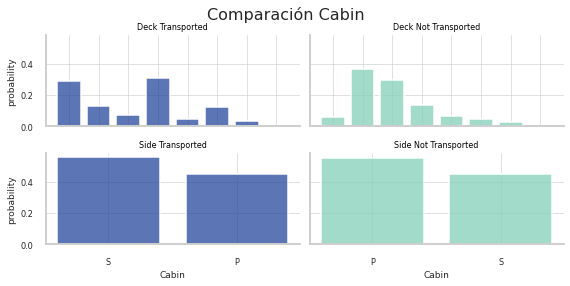

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), sharey=True);
fig.suptitle('Comparación Cabin', size = 16) #Titulo para la figura

#Grafico Deck Usuarios Transportados
transported_deck = sns.histplot(df_new_cols[df_new_cols.Transported ==True].CabinDeck, 
                           discrete=True, shrink=.8, stat="probability", ax = axes[0,0],color = color1);
transported_deck.set_title("Deck Transported", size=8, color='black');

#Grafico Deck Usuarios No Transportados
stay_deck = sns.histplot(df_new_cols[df_new_cols.Transported ==False].CabinDeck, 
                         discrete=True, shrink=.8, stat="probability", ax = axes[0,1],color = color2);
stay_deck.set_title("Deck Not Transported", size=8, color='black');

#Grafico Side Usuarios Transportados
transported_side = sns.histplot(df_new_cols[df_new_cols.Transported ==True].CabinSide, 
                           discrete=True, shrink=.8, stat="probability", ax = axes[1,0],color = color1);
transported_side.set_title("Side Transported", size=8, color='black');

#Grafico Side Usuarios No Transportados
stay_side = sns.histplot(df_new_cols[df_new_cols.Transported ==False].CabinSide, 
                         discrete=True, shrink=.8, stat="probability", ax = axes[1,1],color = color2);
stay_side.set_title("Side Not Transported", size=8, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cabin', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

### Transformar Categóricas en Numéricas

In [40]:
df_encoded = df_new_cols.copy()

In [41]:
df_encoded.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'UsedSpa', 'UsedFoodCourt', 'UsedRoomService', 'UsedVRD',
       'UsedShoppingMall', 'CabinDeck', 'CabinNumber', 'CabinSide'],
      dtype='object')

Para transformar las variables categóricas en numéricas, utilizamos LabelEncoder.

In [42]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck', 'CabinSide']
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

### Escalar

Utilizamos RobustScaler para escalar los datos

In [43]:
df_scaled = df_encoded.copy()

#Separamos el numero de identificación de Pasajeros
PassengerId_train = df_scaled.PassengerId
df_scaled.drop(columns='PassengerId', inplace=True)

#Separamos en datos de entrada y salida

y = df_scaled.Transported
df_scaled = df_scaled.drop('Transported',axis = 1)

df_scaled.shape,y.shape

((7823, 17), (7823,))

In [44]:
from sklearn.preprocessing import RobustScaler
train_names = df_scaled.columns
df_scaled = RobustScaler().fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns=train_names)

In [45]:
df_scaled[:5]

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,UsedSpa,UsedFoodCourt,UsedRoomService,UsedVRD,UsedShoppingMall,CabinDeck,CabinNumber,CabinSide
0,1.00,0.00,0.00,1.76,0.00,68.30,0.57,3.90,96.85,1.00,1.00,0.00,1.00,1.00,-1.00,-0.37,0.00
1,2.00,1.00,0.00,-0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,1.00
2,1.00,1.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.33,-0.10,1.00
3,0.00,0.00,0.00,0.94,3.69,21.38,0.00,0.00,5.10,0.00,1.00,1.00,1.00,0.00,0.00,1.21,0.00
4,0.00,0.00,0.00,-0.47,0.00,0.00,29.13,0.02,0.85,1.00,0.00,0.00,1.00,1.00,0.33,-0.50,0.00


### KNN sobre CryoSleep, CabinDeck, CabinNumber y CabinSide

In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

X = df_scaled.copy(deep=True) #hacemos una copia de la matri

#definimos el imputador
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

#lo aplicamos y devuelve un array
X = mice_imputer.fit_transform(X)

#pasamos de array a df y agregamos nombre columnas
X = pd.DataFrame(X, columns=train_names)

In [47]:
X.shape

(7823, 17)

In [48]:
X[:3]

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,UsedSpa,UsedFoodCourt,UsedRoomService,UsedVRD,UsedShoppingMall,CabinDeck,CabinNumber,CabinSide
0,1.00,0.00,0.00,1.76,0.00,68.30,0.57,3.90,96.85,1.00,1.00,0.00,1.00,1.00,-1.00,-0.37,0.00
1,2.00,1.00,0.00,-0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,1.00
2,1.00,1.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.33,-0.10,1.00


In [49]:
X.isnull().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
UsedSpa             0
UsedFoodCourt       0
UsedRoomService     0
UsedVRD             0
UsedShoppingMall    0
CabinDeck           0
CabinNumber         0
CabinSide           0
dtype: int64

## Preprocesamiento Test

Todas la limpieza realizada anteriormente debe repetirse en el conjunto de Test

### Tratamiento Datos Faltantes

In [50]:
#Remplazamos Servicios para los menores de edad
df_test_analisis.FoodCourt=np.where(df_test_analisis.Age < 13, df_test_analisis.FoodCourt.fillna(0),df_test_analisis.FoodCourt)
df_test_analisis.ShoppingMall=np.where(df_test_analisis.Age < 13, df_test_analisis.ShoppingMall.fillna(0),df_test_analisis.ShoppingMall)
df_test_analisis.RoomService=np.where(df_test_analisis.Age < 13, df_test_analisis.RoomService.fillna(0),df_test_analisis.RoomService)
df_test_analisis.Spa=np.where(df_test_analisis.Age < 13, df_test_analisis.Spa.fillna(0),df_test_analisis.Spa)
df_test_analisis.VRDeck=np.where(df_test_analisis.Age < 13, df_test_analisis.VRDeck.fillna(0),df_test_analisis.VRDeck)

In [51]:
#Remplazamos Servicios para los mayores de edad
df_test_analisis.FoodCourt=np.where(df_test_analisis.Age > 12, df_test_analisis.FoodCourt.fillna(df_test_analisis.FoodCourt.median()),df_test_analisis.FoodCourt)
df_test_analisis.ShoppingMall=np.where(df_test_analisis.Age > 12, df_test_analisis.ShoppingMall.fillna(df_test_analisis.ShoppingMall.median()),df_test_analisis.ShoppingMall)
df_test_analisis.RoomService=np.where(df_test_analisis.Age > 12, df_test_analisis.RoomService.fillna(df_test_analisis.RoomService.median()),df_test_analisis.RoomService)
df_test_analisis.Spa=np.where(df_test_analisis.Age > 12, df_test_analisis.Spa.fillna(df_test_analisis.Spa.median()),df_test_analisis.Spa)
df_test_analisis.VRDeck=np.where(df_test_analisis.Age > 12, df_test_analisis.VRDeck.fillna(df_test_analisis.VRDeck.median()),df_test_analisis.VRDeck)

In [52]:
#Remplazamos Servicios para los pasajeros donde Age es Nan
df_test_analisis.FoodCourt=np.where(df_test_analisis.Age.isnull(),df_test_analisis.FoodCourt.fillna(df_test_analisis.FoodCourt.median()),df_test_analisis.FoodCourt)
df_test_analisis.ShoppingMall=np.where(df_test_analisis.Age.isnull(),df_test_analisis.ShoppingMall.fillna(df_test_analisis.ShoppingMall.median()),df_test_analisis.ShoppingMall)
df_test_analisis.RoomService=np.where(df_test_analisis.Age.isnull(), df_test_analisis.RoomService.fillna(df_test_analisis.RoomService.median()), df_test_analisis.RoomService)
df_test_analisis.Spa=np.where(df_test_analisis.Age.isnull(), df_test_analisis.Spa.fillna(df_test_analisis.Spa.median()),df_test_analisis.Spa)
df_test_analisis.VRDeck=np.where(df_test_analisis.Age.isnull(), df_test_analisis.VRDeck.fillna(df_test_analisis.VRDeck.median()),df_test_analisis.VRDeck)

In [53]:
#VIP y Name (eliminamos columnas)
df_test_analisis.drop(columns=['VIP','Name'], inplace=True)

In [54]:
#Age por Mediana
df_test_analisis.Age = df_test_analisis.Age.fillna(df_test_analisis.Age.median())

In [55]:
#Destino y Home Planet (sin grupo familiar) por moda
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
df_test_analisis[['Destination','HomePlanet']]= imputer.fit_transform(df_test_analisis[['Destination','HomePlanet']])

### Agregamos las columnas

In [56]:
#Agregamos las columnas Uso de Servicios para el conjunto de Test

df_test_analisis.loc[:, 'UsedSpa'] = df_test_analisis.Spa.apply(used_service)
df_test_analisis.loc[:, 'UsedFoodCourt'] = df_test_analisis.FoodCourt.apply(used_service)
df_test_analisis.loc[:, 'UsedRoomService'] = df_test_analisis.RoomService.apply(used_service)
df_test_analisis.loc[:, 'UsedVRD'] = df_test_analisis.VRDeck.apply(used_service)
df_test_analisis.loc[:, 'UsedShoppingMall'] = df_test_analisis.ShoppingMall.apply(used_service)

In [57]:
#Agregamos las columnas de Cabin para el conjunto de Test
df_test_analisis.loc[:, 'CabinDeck'] = df_test_analisis.Cabin.apply(split_deck)
df_test_analisis.loc[:, 'CabinNumber'] = df_test_analisis.Cabin.apply(split_cnum)
df_test_analisis.loc[:, 'CabinSide'] = df_test_analisis.Cabin.apply(split_side)

In [58]:
df_test_analisis.drop(columns='Cabin', inplace=True)

In [59]:
df_test_analisis.isnull().sum()

PassengerId          0
HomePlanet           0
CryoSleep           21
Destination          0
Age                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
UsedSpa              0
UsedFoodCourt        0
UsedRoomService      0
UsedVRD              0
UsedShoppingMall     0
CabinDeck           15
CabinNumber         15
CabinSide           15
dtype: int64

###Encoding y Escalado

In [60]:
df_test_preproc = df_test_analisis.copy()

In [61]:
PassengerId_test = df_test_preproc.PassengerId
df_test_preproc.drop(columns='PassengerId', inplace=True)

In [62]:
for col in categorical_cols:
    df_test_preproc[col] = df_test_preproc[col].astype(str)
    df_test_preproc[col] = LabelEncoder().fit_transform(df_test_preproc[col])

In [63]:
test_names = df_test_preproc.columns
df_test_preproc = RobustScaler().fit_transform(df_test_preproc)
df_test_preproc = pd.DataFrame(df_test_preproc, columns=test_names)

### KNN sobre Cabin

In [64]:
X_test = df_test_preproc.copy(deep=True) #hacemos una copia de la matri

#definimos el imputador
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

#lo aplicamos - devuelve un array
X_test = mice_imputer.fit_transform(X_test)

#pasamos de array a df y agregamos nombre columnas
X_test = pd.DataFrame(X_test, columns=test_names)

In [65]:
X_test.shape

(870, 17)

#Aprendizaje Supervisado

## Dividir en Conjunto Entrenamiento y Prueba

Ahora ya tenemos nuestros datos procesados para aplicar los modelos clasificación. Antes, vamos a separar el conjunto de datos del archivo train en datos para entrenar y para validar. 

In [66]:
#Separamos los datos en conjunto de train y test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [67]:
#Veamos el tamaño de cada conjunto
X_train.shape, X_val.shape

((6258, 17), (1565, 17))

Ahora tenemos 6258 registros en el conjunto sobre el que vamos a entrenar y 1565 registros sobre el que vamos a validar.

In [68]:
#Veamos las proporciones
from collections import Counter

print('Balance de clases conjunto entrenamiento {}'.format(Counter(y_train)))
print('Balance de clases conjunto prueba {}'.format(Counter(y_val)))

Balance de clases conjunto entrenamiento Counter({1: 3177, 0: 3081})
Balance de clases conjunto prueba Counter({1: 787, 0: 778})


Los conjuntos se encuentran relativamente balanceados.

## Modelos

Vamos a probar diferentes modelos de clasificación y ver cuáles ajustan mejor dado los datos. Nuestro objetivo es maximizar la accuracy. 

Algunos de las clases de scikit-learn que vamos a probar son:

- DummyClassifier
- LogisticRegression
- SGDClassifier
- LinearSVC
- Perceptron
- DecisionTreeClassifier
- RandomForestClassifier
- GradientBoostingClassifier

In [69]:
#Fijamos Parametros Grls
RANDOM_STATE = 45 

Si bien nuestro objetivo es maximizar la accuracy de nuestro modelo. Vamos a medir también las metricas de precisión, recall y F1. 

Para simplificar el proceso, definimos una función evaluadora:

In [70]:
#Definimos la función de metricas
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

def metricas(a,b):
  print(f"Accuracy: %.4f" % (accuracy_score(a, b)), '\n'
  f"Presicion: %.4f" % (precision_score(a, b)), '\n'
  f"Recall: %.4f" % (recall_score(a, b)), '\n'
  f"F1: %.4f" % (f1_score(a, b)), '\n')

> #### DummyClassifier

Vamos a comenzar con el modelo más básico:

In [71]:
#Modelo Basico
from sklearn.dummy import DummyClassifier

#Entrenar
dummy_clf = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=45, strategy='stratified')

In [72]:
# Predecimos y evaluamos sobre train
y_train_predict_dummy = dummy_clf.predict(X_train)
metricas(y_train, y_train_predict_dummy)

Accuracy: 0.4986 
Presicion: 0.5061 
Recall: 0.5080 
F1: 0.5071 



In [73]:
# Predecimos y evaluamos sobre validación
y_val_predict_dummy = dummy_clf.predict(X_val)
metricas(y_val, y_val_predict_dummy)

Accuracy: 0.5150 
Presicion: 0.5172 
Recall: 0.5337 
F1: 0.5253 



Este modelo nos da valores muy pobres.

> #### Modelos Lineales

In [74]:
#Modelos Lineales
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC

clfs_lineal = [LogisticRegression(random_state=RANDOM_STATE), SGDClassifier(random_state=RANDOM_STATE), 
                LinearSVC(random_state=RANDOM_STATE), Perceptron(random_state=RANDOM_STATE)]
names_lineal = ['Regresión logística', 'Descenso del gradiente estocastico', 'SVM','Perceptron']

In [75]:
trained_models = []
for clf,name in zip(clfs_lineal,names_lineal):
    print(name)

    # Entrenamiento del modelo
    clf.fit(X_train, y_train)

    # Predicción con train
    train_predictions = clf.predict(X_train)
    print("Train metrics:")
    metricas(y_train, train_predictions)

    # Predicción con validación
    val_predictions = clf.predict(X_val)
    print("Validation metrics: ")
    metricas(y_val, val_predictions)

    trained_models.append(clf)

Regresión logística


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train metrics:
Accuracy: 0.7899 
Presicion: 0.7706 
Recall: 0.8344 
F1: 0.8013 

Validation metrics: 
Accuracy: 0.7981 
Presicion: 0.7890 
Recall: 0.8170 
F1: 0.8027 

Descenso del gradiente estocastico
Train metrics:
Accuracy: 0.7514 
Presicion: 0.7214 
Recall: 0.8313 
F1: 0.7724 

Validation metrics: 
Accuracy: 0.7623 
Presicion: 0.7355 
Recall: 0.8234 
F1: 0.7770 

SVM
Train metrics:
Accuracy: 0.7651 
Presicion: 0.7165 
Recall: 0.8892 
F1: 0.7935 

Validation metrics: 
Accuracy: 0.7879 
Presicion: 0.7423 
Recall: 0.8856 
F1: 0.8076 

Perceptron
Train metrics:
Accuracy: 0.7665 
Presicion: 0.7447 
Recall: 0.8218 
F1: 0.7814 

Validation metrics: 
Accuracy: 0.7796 
Presicion: 0.7588 
Recall: 0.8234 
F1: 0.7898 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Estos modelos otorgan mejores métricas que los anteriores.

> #### Modelos Basados en Arboles

In [76]:
#Modelos Basados en Arboles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clfs_trees = [DecisionTreeClassifier(random_state=RANDOM_STATE), 
              RandomForestClassifier(random_state=RANDOM_STATE), 
              GradientBoostingClassifier(random_state=RANDOM_STATE)]
names_trees = ['Arbol de decision', 'Random forest', 'Gradient boosting']

In [77]:
trained_models = []
for clf,name in zip(clfs_trees,names_trees):
    print(name)

    # Entrenamiento del modelo
    clf.fit(X_train, y_train)

    # Predicción con train
    train_predictions = clf.predict(X_train)
    print("Train metrics:")
    metricas(y_train, train_predictions)

    # Predicción con validación
    val_predictions = clf.predict(X_val)
    print("Validation metrics: ")
    metricas(y_val, val_predictions)

    trained_models.append(clf)

Arbol de decision
Train metrics:
Accuracy: 0.9997 
Presicion: 1.0000 
Recall: 0.9994 
F1: 0.9997 

Validation metrics: 
Accuracy: 0.7233 
Presicion: 0.7258 
Recall: 0.7230 
F1: 0.7244 

Random forest
Train metrics:
Accuracy: 0.9995 
Presicion: 1.0000 
Recall: 0.9991 
F1: 0.9995 

Validation metrics: 
Accuracy: 0.8089 
Presicion: 0.8427 
Recall: 0.7624 
F1: 0.8005 

Gradient boosting
Train metrics:
Accuracy: 0.8236 
Presicion: 0.8093 
Recall: 0.8536 
F1: 0.8309 

Validation metrics: 
Accuracy: 0.8089 
Presicion: 0.7998 
Recall: 0.8272 
F1: 0.8132 



Estos modelos devuelven mejores resultados, aunque claramente estan sobreajustando. 

## Ajuste HiperParametros

Ahora vamos a probar con distintos hiperparametros. Para ello, utilizaremos las herramientas GridSearch y KFolds. Solo lo aplicaremos sobre los modelos que mejores resultados arrojaron en la etapa anterior:

- DecisionTreeClassifier
- RandomForestClassifier
- GradientBoostingClassifier
- LogisticRegression
- LinearSVC



In [78]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

###GridSearch

> #### DecisionTreeClassifier



In [79]:
#Parametros a comparar:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter':("best","random"),
    'max_depth': [i for i in range(3,13)],
    'min_samples_split': (2,5,10),
    'max_features': ['auto', None]
}

#Modelo a aplicar
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [80]:
#Aplicamos GridSearch
grid_tree = GridSearchCV(model_tree, param_grid_tree, scoring='accuracy', cv=None) 
grid_tree.fit(X_train, y_train);
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'min_samples_split': 2,
 'splitter': 'best'}

Train metrics:
Accuracy: 0.8092 
Presicion: 0.8015 
Recall: 0.8297 
F1: 0.8153 

Validation metrics: 
Accuracy: 0.7936 
Presicion: 0.7864 
Recall: 0.8094 
F1: 0.7977 



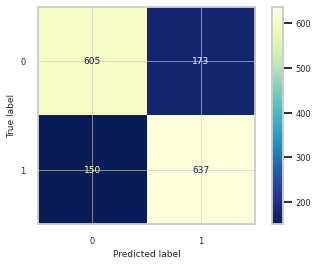

In [81]:
#Definimos el arbol con los mejores parametros identificados
best_model_tree = DecisionTreeClassifier(**grid_tree.best_params_).fit(X_train, y_train)

#Predecimos y evaluamos sobre Train
train_predictions_tree = best_model_tree.predict(X_train)
print("Train metrics:")
metricas(y_train, train_predictions_tree)  #con 8 da 82%

#Predecimos y evaluamos sobre Validation
val_predictions_tree = best_model_tree.predict(X_val)
print("Validation metrics: ")
metricas(y_val, val_predictions_tree) #con 8 da 78%

cm = confusion_matrix(y_val, val_predictions_tree)
ConfusionMatrixDisplay(cm).plot(cmap="YlGnBu_r")
plt.show()

Supera al modelo de baseline propuesto por la catedra. Sin embargo, está sobreajustando.

> #### Random Forest

In [82]:
#Parametros a comparar:
param_grid_forest = { 
    'n_estimators': [50],
    'max_features': ['sqrt'], #'log2', None
    'max_depth' : [17,30,50,100,150], #[4,5,6,15,30] [i for i in range(13,17)]
    'criterion' :['entropy'], #'gini', 
    'min_samples_split' : [2,3,10],
    'min_samples_leaf':[4,5,6,20]
}
#Modelo a aplicar
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

In [83]:
#Aplicamos GridSearch
grid_forest = GridSearchCV(model_forest, param_grid_forest, scoring='accuracy', cv=None) 
grid_forest.fit(X_train, y_train);
grid_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

Train metrics:
Accuracy: 0.8786 
Presicion: 0.8720 
Recall: 0.8917 
F1: 0.8817 

Validation metrics: 
Accuracy: 0.8019 
Presicion: 0.8069 
Recall: 0.7967 
F1: 0.8018 



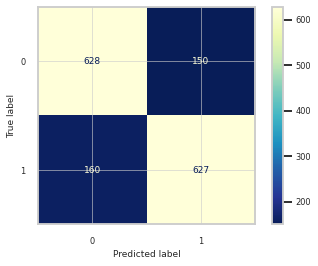

In [84]:
#Definimos el arbol con los mejores parametros identificados
best_model_forest = RandomForestClassifier(**grid_forest.best_params_).fit(X_train, y_train)

#Predecimos y evaluamos sobre Train
train_predictions_forest = best_model_forest.predict(X_train)
print("Train metrics:")
metricas(y_train, train_predictions_forest)

#Predecimos y evaluamos sobre Validation
val_predictions_forest = best_model_forest.predict(X_val)
print("Validation metrics: ")
metricas(y_val, val_predictions_forest)

cm = confusion_matrix(y_val, val_predictions_forest)
ConfusionMatrixDisplay(cm).plot(cmap="YlGnBu_r")
plt.show()

Supera al modelo de baseline propuesto por la catedra y al modelo DecisionTreeClassifier propuesto en el inciso anterior. Sin embargo, está sobreajustando.

> #### GradientBoostingClassifier

In [85]:
#Parametros a comparar:
param_grid_gradient = {
    'learning_rate':[0.2], #0.1,
    'n_estimators':[100], #50,70,110
    'subsample':[1.0], #0.0,0.5,
    'criterion':['friedman_mse'], #, 'squared_error'
    'min_samples_split' : [2], #,3
    'min_samples_leaf':[5,8,10], #,1,5,8
    'max_depth':[3,4] #2,3,5,10
}

#Modelo a aplicar
model_gradient = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [ ]:
#Aplicamos GridSearch
grid_gradient = GridSearchCV(model_gradient, param_grid_gradient, scoring='accuracy', cv=None) 
grid_gradient.fit(X_train, y_train);
grid_gradient.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 1.0}

Train metrics:
Accuracy: 0.8663 
Presicion: 0.8598 
Recall: 0.8801 
F1: 0.8698 

Validation metrics: 
Accuracy: 0.8121 
Presicion: 0.8093 
Recall: 0.8196 
F1: 0.8144 



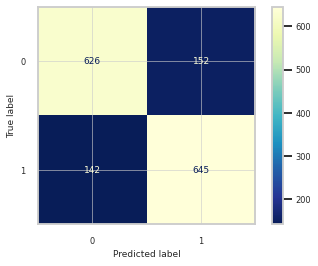

In [ ]:
#Definimos el arbol con los mejores parametros identificados
best_model_gradient = GradientBoostingClassifier(**grid_gradient.best_params_).fit(X_train, y_train)

#Predecimos y evaluamos sobre Train
train_predictions_gradient = best_model_gradient.predict(X_train)
print("Train metrics:")
metricas(y_train, train_predictions_gradient)

#Predecimos y evaluamos sobre Validation
val_predictions_gradient = best_model_gradient.predict(X_val)
print("Validation metrics: ")
metricas(y_val, val_predictions_gradient)

cm = confusion_matrix(y_val, val_predictions_gradient)
ConfusionMatrixDisplay(cm).plot(cmap="YlGnBu_r")
plt.show()

Devuelve mejores resultados que el modelo de baseline planteado por los profesores y que los otros dos modelos planteados por nosotros. 

> #### LogisticRegression

In [ ]:
#Parametros a comparar:
param_grid_logistic = {
    'penalty':['l2','l1'], #'elasticnet', , 'none'
    'max_iter': [3000],
    'solver':['liblinear','sag'] #'liblinear','newton-cg', 'lbfgs', 'saga'
}

#Modelo a aplicar
model_logistic = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
#Aplicamos GridSearch
grid_logistic = GridSearchCV(model_logistic, param_grid_logistic, scoring='accuracy', cv=None) 
grid_logistic.fit(X_train, y_train);
grid_logistic.best_params_

#En algunos no lo puede hacer pq l1 y sag no son compatibles.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Train metrics:
Accuracy: 0.7888 
Presicion: 0.7697 
Recall: 0.8332 
F1: 0.8002 

Validation metrics: 
Accuracy: 0.7962 
Presicion: 0.7861 
Recall: 0.8170 
F1: 0.8012 



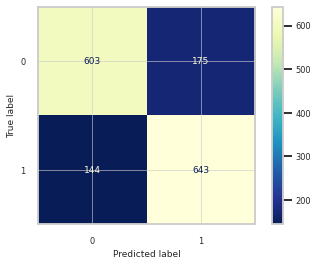

In [ ]:
#Definimos el arbol con los mejores parametros identificados
best_model_logistic = LogisticRegression(**grid_logistic.best_params_).fit(X_train, y_train)

#Predecimos y evaluamos sobre Train
train_predictions_logistic = best_model_logistic.predict(X_train)
print("Train metrics:")
metricas(y_train, train_predictions_logistic)  #79,48

#Predecimos y evaluamos sobre Validation
val_predictions_logistic = best_model_logistic.predict(X_val)
print("Validation metrics: ")
metricas(y_val, val_predictions_logistic) #78,66

cm = confusion_matrix(y_val, val_predictions_logistic)
ConfusionMatrixDisplay(cm).plot(cmap="YlGnBu_r")
plt.show()

Es el modelo con menos overfitting pero con accuracy más baja hasta ahora.

> #### LinearSVC

In [ ]:
#Parametros a comparar:
param_grid_svc = {
    'penalty':['l2'], #'l1',
    'loss':['hinge','squared_hinge'], #si elije l2 probar , 'squared_hinge'
    'dual':[True, False],
    'max_iter': [3000,4000,5000]
}

#Modelo a aplicar
model_svc = LinearSVC(random_state=RANDOM_STATE)

In [ ]:
#Aplicamos GridSearch
grid_svc = GridSearchCV(model_svc, param_grid_svc, scoring='accuracy', cv=None) 
grid_svc.fit(X_train, y_train);
grid_svc.best_params_

In [ ]:
#Definimos el arbol con los mejores parametros identificados
best_model_svc = LinearSVC(**grid_svc.best_params_).fit(X_train, y_train)

#Predecimos y evaluamos sobre Train
train_predictions_svc = best_model_svc.predict(X_train)
print("Train metrics:")
metricas(y_train, train_predictions_svc)  #con 15/50 da 97,6%

#Predecimos y evaluamos sobre Validation
val_predictions_svc = best_model_svc.predict(X_val)
print("Validation metrics: ")
metricas(y_val, val_predictions_svc) #con 15/50 da 78,8%

cm = confusion_matrix(y_val, val_predictions_svc)
ConfusionMatrixDisplay(cm).plot(cmap="YlGnBu_r")
plt.show()

Igual que el anterior, poco overfitting pero resultados malos.

### CrossValidation

In [ ]:
from sklearn.model_selection import StratifiedKFold

names = ['Decision Tree','Random Forest','Descenso Gradiente','Regresión Logistica','SVC']
models = [DecisionTreeClassifier(**grid_tree.best_params_),
          GradientBoostingClassifier(**grid_gradient.best_params_),
          RandomForestClassifier(**grid_forest.best_params_),
          LogisticRegression(**grid_logistic.best_params_),
          LinearSVC(**grid_svc.best_params_)]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
lst_accu_stratified = []

x_train2 = np.array(X_train)
y_train2 = np.array(y_train)

for clfi, name in zip(models,names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(skf.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión validation fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= 5
    print(f'Avg. accuracy = {avg_accuracy * 100}')

## Generamos la salida

Sobre los datos de test, aplicamos los dos mejores modelos:
- Descenso del Gradiente 
- Random Forest

In [ ]:
test_id = PassengerId_test

clf_forest = RandomForestClassifier(**grid_forest.best_params_).fit(X_train, y_train)
clf_gradient = GradientBoostingClassifier(**grid_gradient.best_params_).fit(X_train, y_train)

test_pred_forest = clf_forest.predict(X_test)
test_pred_gradiente = clf_gradient.predict(X_test)

In [ ]:
submission_gradient = pd.DataFrame(list(zip(test_id, test_pred_gradiente)), columns=["PassengerId", "Transported"])
submission_gradient.to_csv("sample_submission_gradient.csv", header=True, index=False)

In [ ]:
submission_forest = pd.DataFrame(list(zip(test_id, test_pred_forest)), columns=["PassengerId", "Transported"])
submission_forest.to_csv("sample_submission_forest.csv", header=True, index=False)

In [ ]:
from google.colab import files
files.download('sample_submission_forest.csv') 
files.download('sample_submission_gradient.csv') 